###  Import the basic modules

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import datetime
from sklearn import model_selection, preprocessing
import xgboost as xgb
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

### Import the data

In [2]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
print(train_df.shape)
print(test_df.shape)

(30471, 292)
(7662, 291)


In [3]:
train_df.sample(3).transpose()

,22770,9643,8983
id,22773,9646,8986
timestamp,2014-09-22,2013-08-06,2013-07-05
full_sq,52,50,77
life_sq,21,29,41
floor,6,1,10
max_floor,16,5,NaN
material,1,2,NaN
build_year,1979,1937,NaN
num_room,2,2,NaN
kitch_sq,8,9,NaN


### Explore the data

#### Price doc Distribution

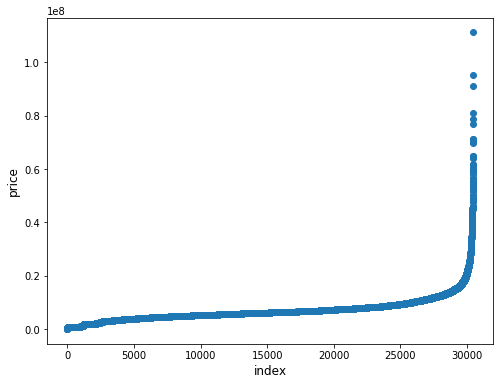

In [4]:
#针对目标值'price_doc'绘制散点图，观察是否有异常值
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.price_doc.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

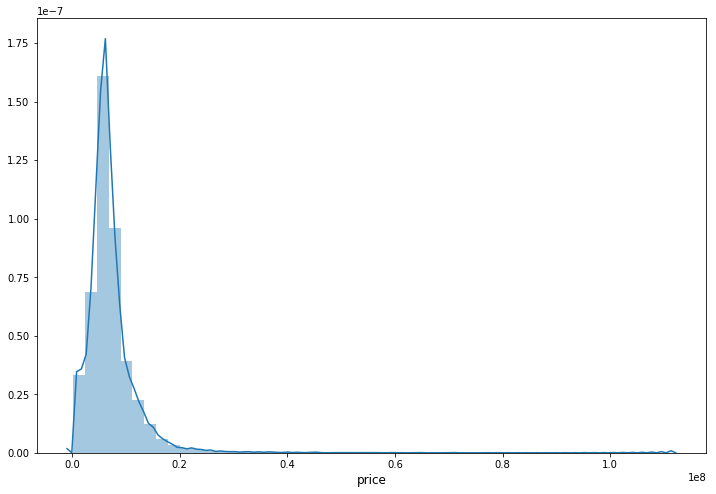

In [5]:
#用'price_doc'绘制直方图
plt.figure(figsize=(12,8))
sns.distplot(train_df.price_doc.values, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

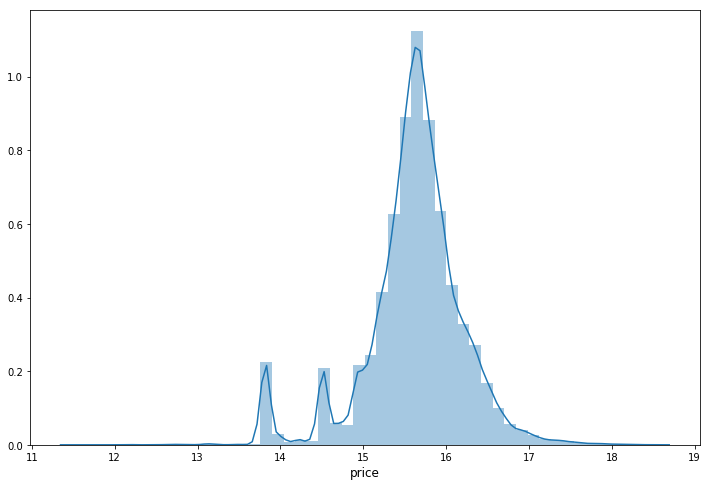

In [6]:
#由于评价指标是对数误差，对'price_doc'的值取对数
plt.figure(figsize=(12,8))
sns.distplot(np.log(train_df.price_doc.values), bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

#### Visualizing datatypes of features

[Text(0,0.5,'Count'),
 Text(0.5,0,'Variable Type'),
 Text(0.5,1,'Variables Count Across Datatype')]

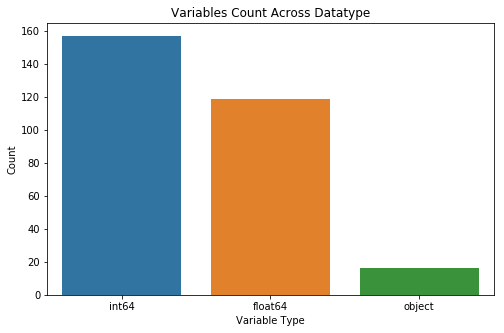

In [7]:
dataTypeDf = pd.DataFrame(train_df.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(8,5)
sns.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax)
ax.set(xlabel='Variable Type', ylabel='Count',title="Variables Count Across Datatype")

#### Missing value analysis

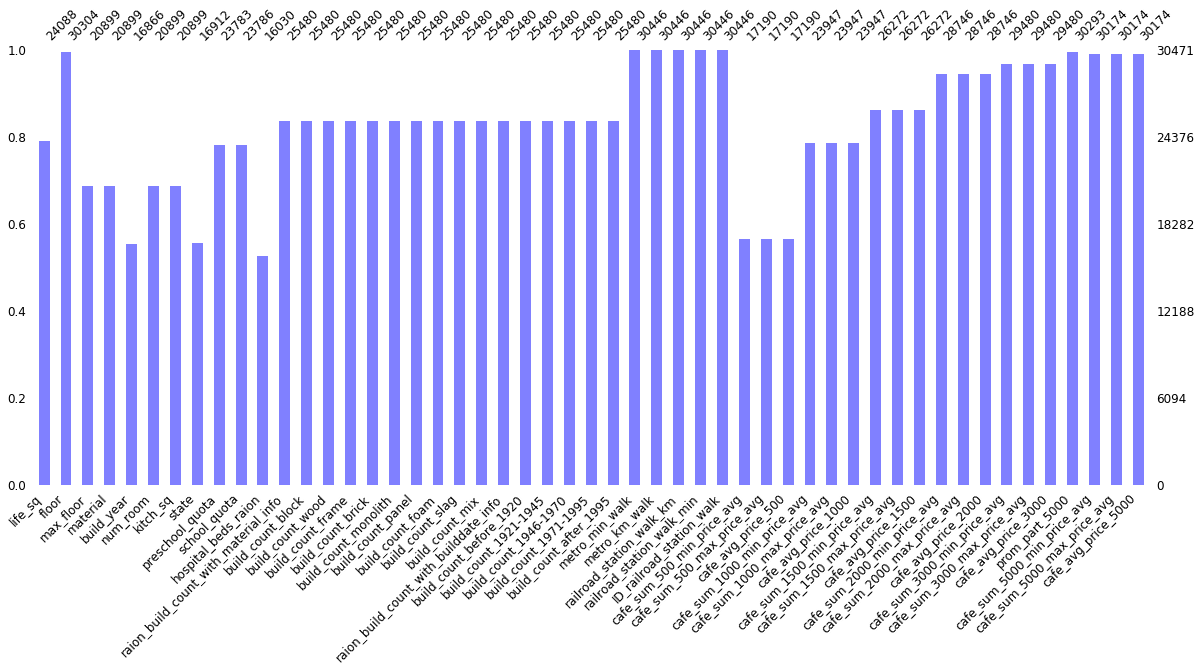

In [8]:
missingValueColumns = train_df.columns[train_df.isnull().any()].tolist()
msno.bar(train_df[missingValueColumns],\
            figsize=(20,8),color=(0.5, 0.5, 1),fontsize=12,labels=True,)

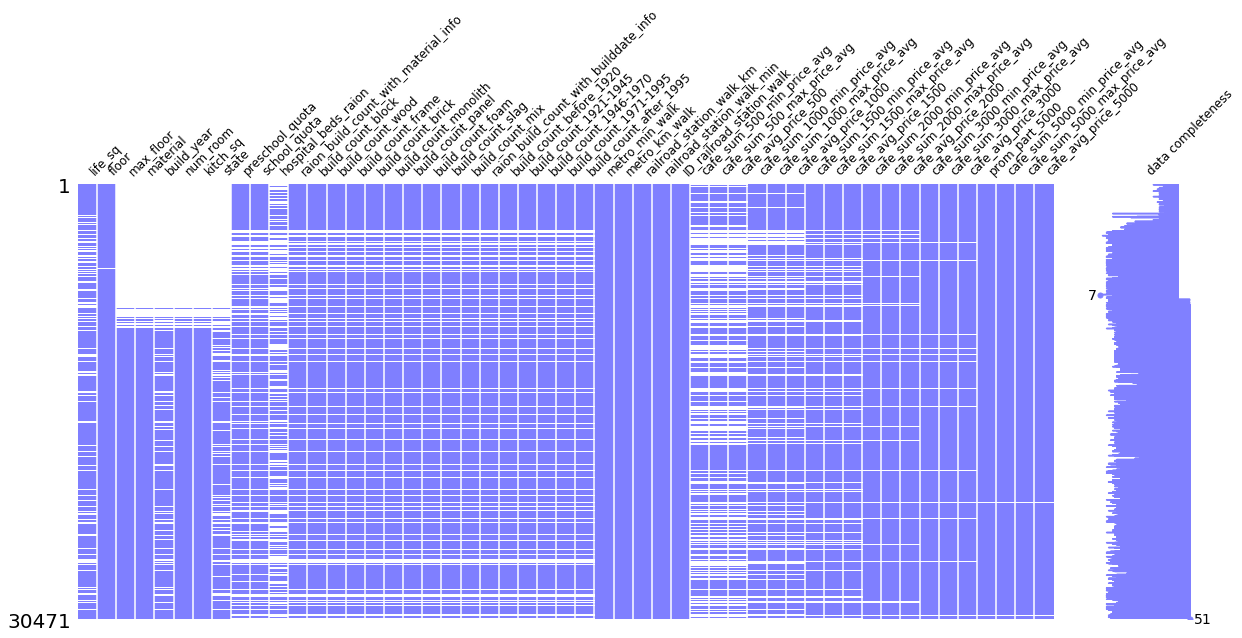

In [9]:
msno.matrix(train_df[missingValueColumns],width_ratios=(10,1),\
            figsize=(20,8),color=(0.5, 0.5, 1),fontsize=12,sparkline=True,labels=True)

### Finding most important features with XGB

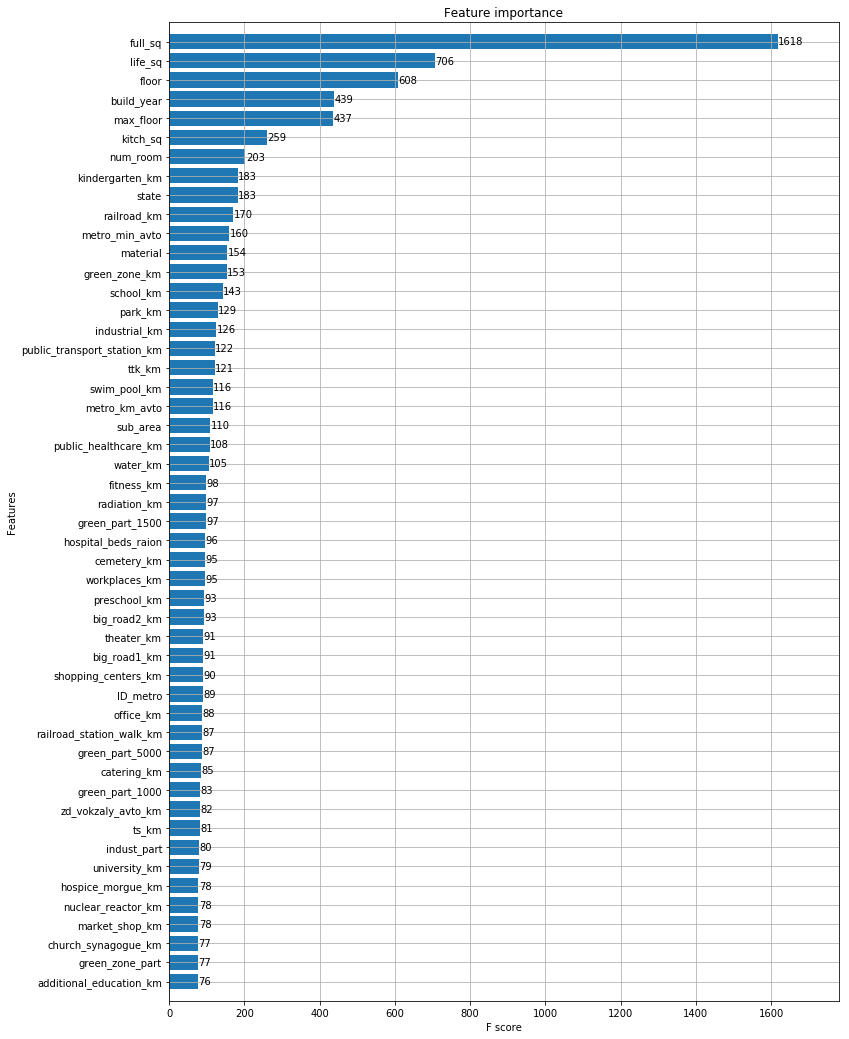

In [10]:
for f in train_df.columns:
    if train_df[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values)) 
        train_df[f] = lbl.transform(list(train_df[f].values))
        
train_y = train_df.price_doc.values
train_X = train_df.drop(["id", "timestamp", "price_doc"], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()


最重要特征Top 5：

 1. full_sq - 总面积，包括凉廊、阳台及其他非居住区域
 2. life_sq - 生活区域面积，不包括凉廊、阳台及其他非居住区域
 3. floor - 在公寓楼中的层数
 4. max_floor - 建筑的最高层数
 5. build_year - 建造年份

### Correlation Analysis

#### Full Square vs Price doc

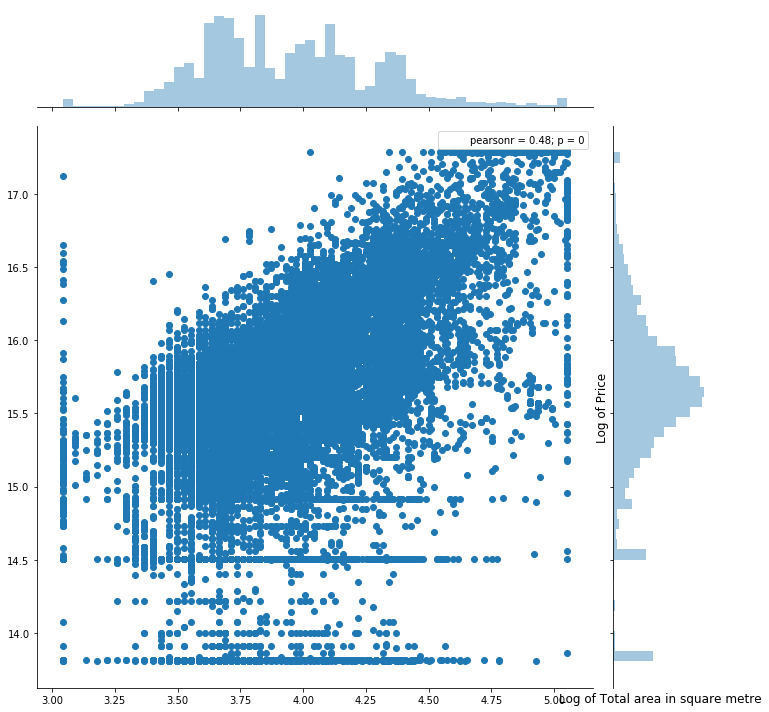

In [15]:

ulimit = np.percentile(train_df.price_doc.values, 99.5)
llimit = np.percentile(train_df.price_doc.values, 0.5)
train_df['price_doc'].loc[train_df['price_doc']>ulimit] = ulimit
train_df['price_doc'].loc[train_df['price_doc']<llimit] = llimit

col = "full_sq"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].loc[train_df[col]>ulimit] = ulimit
train_df[col].loc[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=np.log1p(train_df.full_sq.values), y=np.log1p(train_df.price_doc.values), size=10)
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Log of Total area in square metre', fontsize=12)
plt.show()

#### Life Square vs Price doc

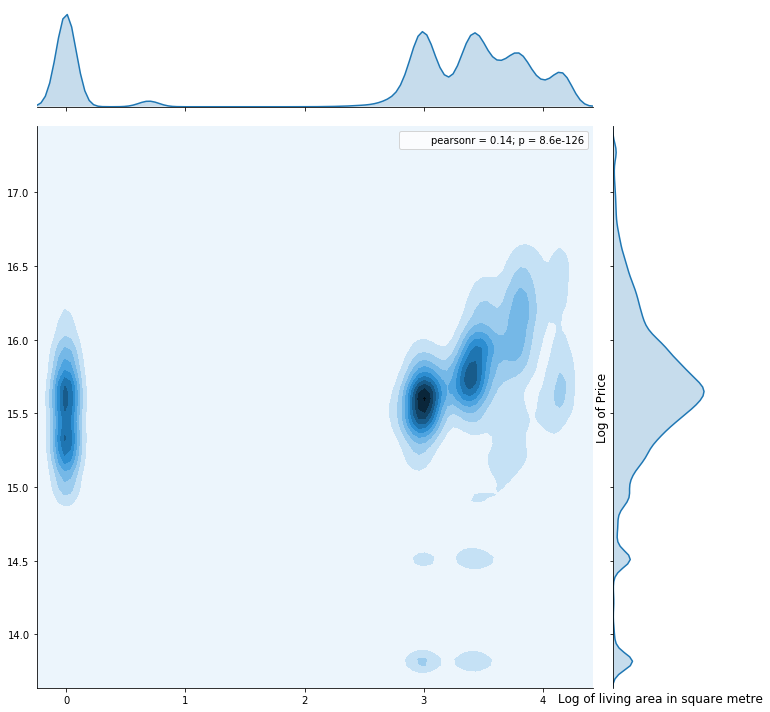

In [16]:
col = "life_sq"
train_df[col].fillna(0, inplace=True)
ulimit = np.percentile(train_df[col].values, 95)
llimit = np.percentile(train_df[col].values, 5)
train_df[col].ix[train_df[col]>ulimit] = ulimit
train_df[col].ix[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=np.log1p(train_df.life_sq.values), y=np.log1p(train_df.price_doc.values), 
              kind='kde', size=10)
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Log of living area in square metre', fontsize=12)
plt.show()

#### Floor vs Price doc

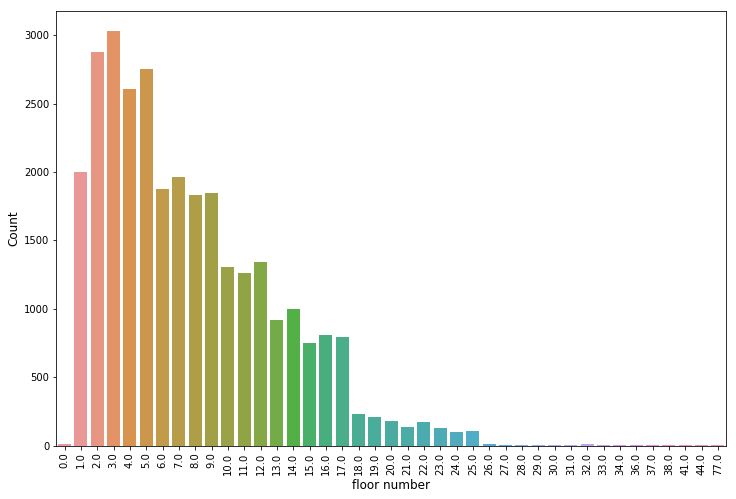

In [17]:
# counting number of floor
plt.figure(figsize=(12,8))
sns.countplot(x="floor", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

The distribution is right skewed. There are some good drops in between (5 to 6, 9 to 10, 12 to 13, 17 to 18).

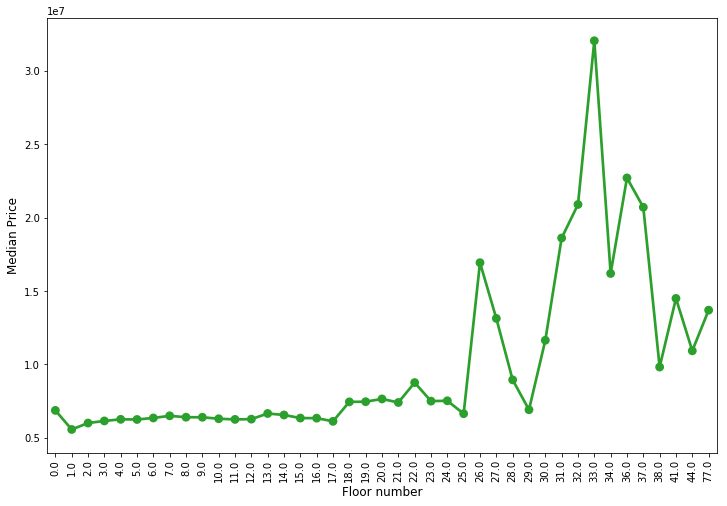

In [18]:
# correlation between floors and price
grouped_df = train_df.groupby('floor')['price_doc'].aggregate(np.median).reset_index()
plt.figure(figsize=(12,8))
sns.pointplot(grouped_df.floor.values, grouped_df.price_doc.values, alpha=0.8, color=color[2])
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

This shows an overall increasing trend (individual houses seems to be costlier as well - check price of 0 floor houses). 
A sudden increase in the house price is also observed at floor 18.

#### Max Floor vs Price doc

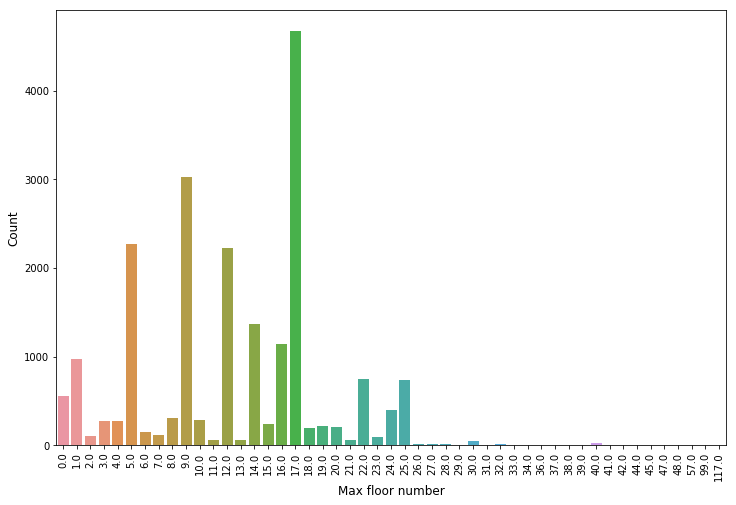

In [19]:
# Count number of max floor
plt.figure(figsize=(12,8))
sns.countplot(x="max_floor", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Max floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

We could see that there are few tall bars in between (at 5,9,12,17 - similar to drop in floors in the previous graph). May be there are some norms / restrictions on the number of maximum floors present(?). 

Now let us see how the median prices vary with the max floors. 

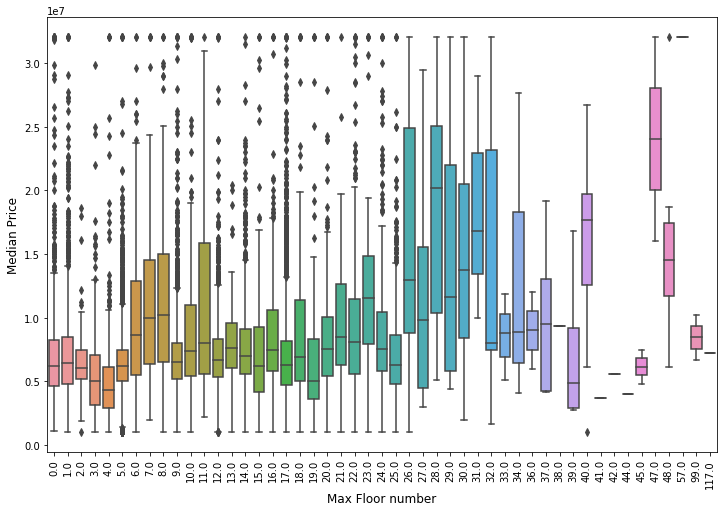

In [20]:
# Correlation between max floors and price
plt.figure(figsize=(12,8))
sns.boxplot(x="max_floor", y="price_doc", data=train_df)
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Max Floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

#### Build Year vs Price doc

(0, 70000000)

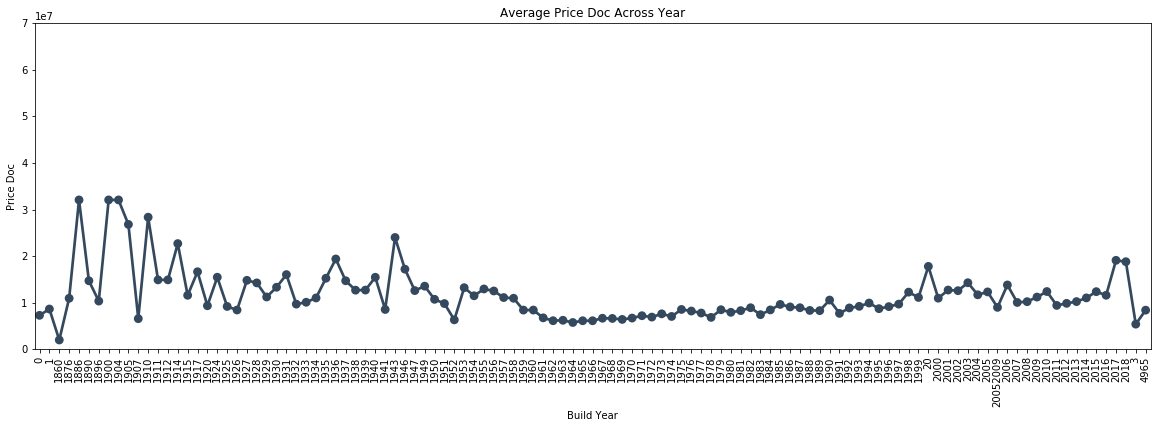

In [21]:
fig,ax= plt.subplots()
fig.set_size_inches(20, 6)
trainBuild = train_df.dropna()
trainBuild["yearbuilt"] = trainBuild["build_year"].map(lambda x:str(x).split(".")[0])
trainBuildGrouped = trainBuild.groupby(["yearbuilt"])["price_doc"].mean().to_frame().reset_index()
sns.pointplot(x=trainBuildGrouped["yearbuilt"], y=trainBuildGrouped["price_doc"], data=trainBuildGrouped, join=True,ax=ax,color="#34495e")
ax.set(xlabel='Build Year', ylabel='Price Doc',title="Average Price Doc Across Year",label='big')
plt.xticks(rotation=90)
plt.ylim([0,70000000])